In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from collections import Counter
sys.path.append('/home/pau/Medical-Diagnosis-Learning/src')
from data_util import *

easy_label_map = {"4019":0, "V290":1}
training_set = load_data_csv('/media/disk3/disk3/notes_sample.csv', easy_label_map)
print("FD of labels:", Counter([_['label'] for _ in training_set]))

PADDING = "<PAD>"
UNKNOWN = "<UNK>"
max_seq_length = 20

word_to_ix, vocab_size, word_counter = build_dictionary([training_set], PADDING, UNKNOWN)
sentences_to_padded_index_sequences(word_to_ix, [training_set], max_seq_length, PADDING, UNKNOWN)


# of data samples:2101854
('FD of labels:', Counter({1: 1072031, 0: 1029823}))


In [4]:
from models import *
batch_size = 256
num_workers = 2
embed_dim = 50
hidden_dim = 100

val_set = training_set[int(0.8*len(training_set)):]
training_set = training_set[:int(0.8*len(training_set))]

train_loader = torch.utils.data.DataLoader(dataset= TextData(training_set), batch_size=batch_size, shuffle=True, 
                                                           num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset= TextData(val_set), batch_size=batch_size, shuffle=True, 
                                                           num_workers=num_workers)


model = LSTMModel(vocab_size, embed_dim, hidden_dim, easy_label_map, batch_size)
opti = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
crit = nn.CrossEntropyLoss()

In [ ]:
from eval import *
step = 0
step_log = []
loss_log = []
val_acc_log = []
for batch in train_loader:
    if batch[0].size(0) != batch_size:
        continue
    model.zero_grad()
    x = Variable(batch[0])
    hidden = model.init_hidden()
    x = model(x, hidden)
    loss = crit(x, Variable(batch[1].view(-1)))
    loss.backward()
    opti.step()
    
    if step % 100 == 0:
        val_acc = evaluate(model, val_loader, batch_size)
        print("Step: %d, Loss: %.4f, Validation Acc: %.2f"%(step, loss.data[0], val_acc))
        step_log.append(step)
        loss_log.append(loss.data[0])
        val_acc_log.append(val_acc)
    step += 1
#     if step == 20:
#         break


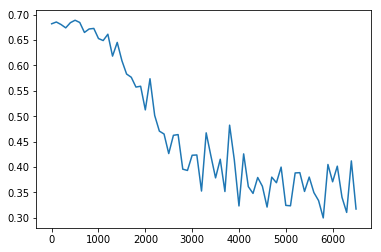

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(step_log, loss_log)